In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import astropy

In [2]:
# Simulates a K2-like lightcurve with red-noisy periodic signal with a step, a trend, and an inserted anomaly
def generate_synthetic_lc(
        num_anomalies=1,
        rednoise_amp=1.0, 
        whitenoise_amp=1.0, 
        num_steps=1000, 
        seed=48
    ):

    assert num_steps > 0, "Number of steps must be greater than 0"
    
    rng = np.random.default_rng(seed=seed)
    x = np.arange(num_steps) # set of points

    # Synthetic signal 
    period = 175 + 50 * rng.random() # randomly chosen period of signal
    phase = 2 * np.pi * rng.random() # randomly chosen phase
    amp = 0.9 * rng.random() # randomly chosen amplitude
    signal = amp * np.cos(2 * np.pi * x / period + phase)

    # White noise 
    whitenoise = whitenoise_amp * rng.random(num_steps)

    # Red noise
    redscale = rng.integers(5, 15) # correlation time scale of red noise
    rednoise = np.convolve(rng.random(2 * num_steps), scipy.signal.windows.gaussian(int(4 * redscale), redscale))
    x1 = int(len(rednoise)/2) - int(num_steps/2)
    x2 = x1 + num_steps
    rednoise = rednoise[x1:x2]
    rednoise = rednoise * rednoise_amp / np.std(rednoise)

    # Step parameters
    step_loc = num_steps * rng.random() # location of step
    step_amp = rng.integers(-3, -1) # amplitude of step
    step_width = rng.integers(15, 25)
    step = step_amp * (x > step_loc) * (x < (step_loc + step_width))

    # Trend parameters
    slope = 0.001 - 0.002 * rng.random() # slope of trend
    trend = slope * (x - num_steps/2)

    # Inject anomalies
    anomaly = np.zeros(num_steps)
    anomaly_locs = []
    
    if num_anomalies > 0:
        anomaly_stdev = rng.integers(3, 10) # width of anomaly
        anomaly_amp = rng.integers(-10, -2) # amplitude of anomaly 
        for i in range(num_anomalies):
            anomaly_loc = num_steps * rng.random()
            anomaly_locs.append(anomaly_loc)
            anomaly += anomaly_amp * np.exp(-0.5 * ((x - anomaly_loc) / anomaly_stdev)**2)  # Gaussian-shape anomaly at x0

    # Combine
    y = signal + anomaly + whitenoise + rednoise + step + trend
    y = y - np.mean(y)

    return x, y, anomaly_locs

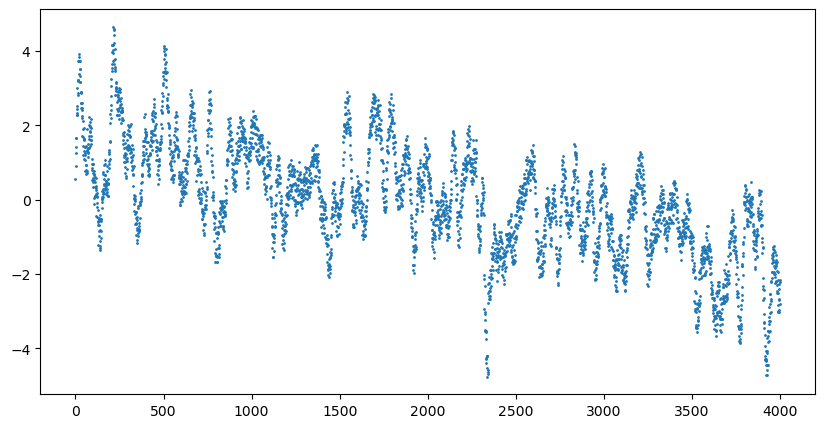

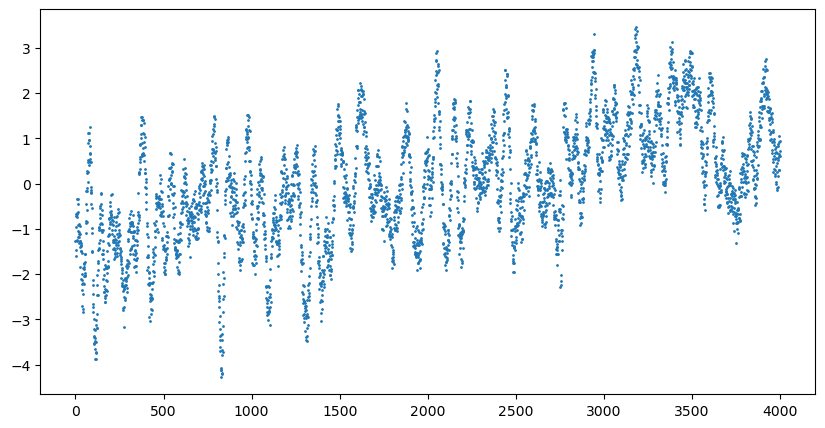

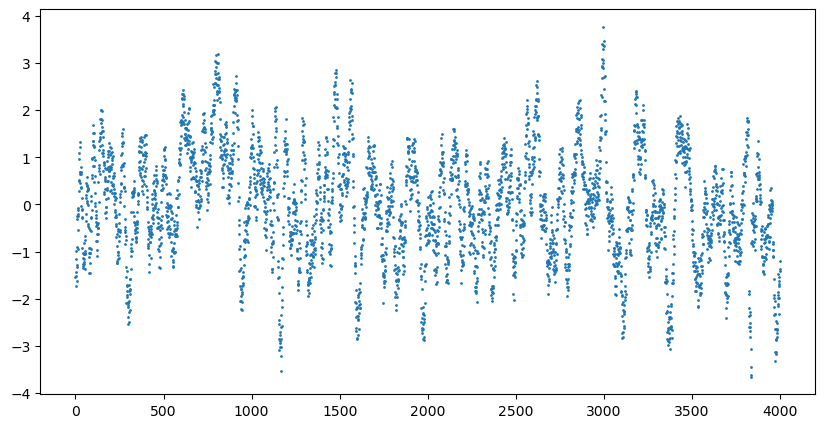

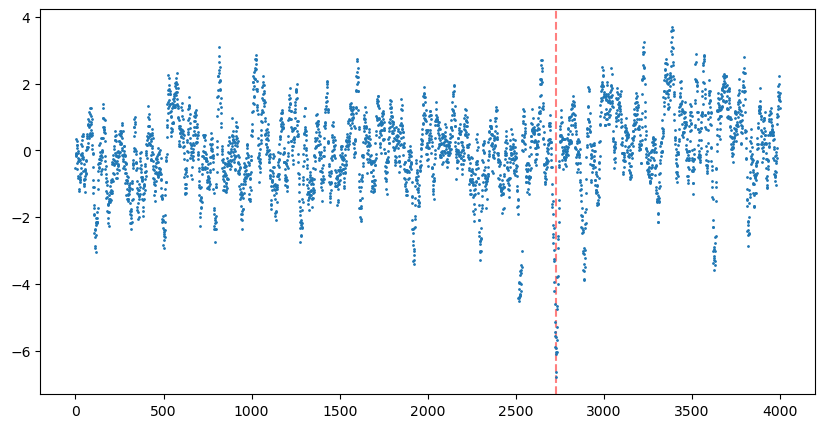

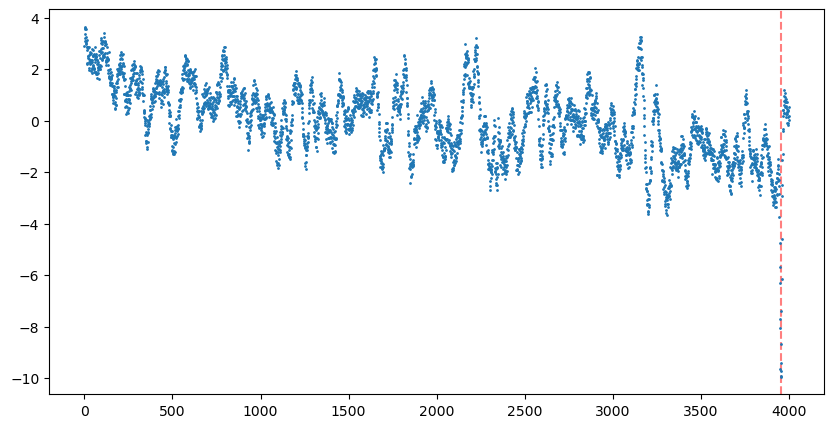

In [3]:
# create a few signals and plot them
for seed in range(15, 20):
    x, y, anomaly_locs = generate_synthetic_lc(num_steps=4000, seed=seed, num_anomalies=np.random.randint(0, 3))
    plt.figure(figsize=(10,5))
    for i in range(len(anomaly_locs)):
        plt.axvline(x=anomaly_locs[i], color='r', linestyle='--', alpha=0.5)
    plt.plot(x, y, '.', markersize=2)
    plt.show()